# Assignment 6

In [1]:
import pandas as pd
import numpy as np

### Q1: Consider the following dataset: 

In [2]:
data = [['sunny',85,85,'false','no'],
       ['sunny',80,90,'true','no'],
       ['overcast',83,78,'false','yes'],
       ['rain',70,96,'false','yes'],
       ['rain',68,80,'false','yes'],
       ['rain',65,70,'true','no'],
       ['overcast',64,65,'true','yes'],
       ['sunny',72,95,'false','no'],
       ['sunny',69,70,'false','yes'],
       ['rain',75,80,'false','yes'],
       ['sunny',75,70,'true','yes'],
       ['overcast',72,90,'true','yes'],
       ['overcast',81,75,'false','yes'],
       ['rain',71,80,'true','no']]
df = pd.DataFrame(data=data,columns=['Outlook','Temperature','Humidity','Windy','Play'])
df

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,85,85,false,no
1,sunny,80,90,true,no
2,overcast,83,78,false,yes
3,rain,70,96,false,yes
4,rain,68,80,false,yes
5,rain,65,70,true,no
6,overcast,64,65,true,yes
7,sunny,72,95,false,no
8,sunny,69,70,false,yes
9,rain,75,80,false,yes


#### (a) Encode the Temperature and Humidity as binary column wit values True/False using a threshold being decided by Gain Ratio. 

In [3]:
def find_entropy(df):
    entropy = 0
    Class = df.keys()[-1]
    outcomes = df[Class].unique()
    for oc in outcomes:
        prob = len(df[Class][df[Class]==oc])/len(df)
        entropy += -(prob*np.log2(prob+1e-10))
    return entropy

In [4]:
find_entropy(df)

0.9402859583820921

In [5]:
#attribute countinuous value to binary
def modify_C2B(df, attribute):
    df2 = df.sort_values(by=[attribute])
    GainRatio = []
    Class = df2.keys()[-1]
    unique_vals = df2[Class].unique()
    for temp in df2[attribute][:-1]:
        entropySub = 0
        avgInfoEntropy = 0
        SplitInfo = 0
        for val in unique_vals:
            num = len(df2[attribute][df2[attribute] <= temp][df2[Class] == val])
            den = len(df2[attribute][df2[attribute] <= temp])
            prob = num/den
            entropySub += -(prob*np.log2(prob+1e-10))
        weight = den/len(df2)
        avgInfoEntropy += weight*entropySub
        SplitInfo += -(weight*np.log2(weight))
        entropySub = 0
        for val in unique_vals:
            num = len(df2[attribute][df2[attribute] > temp][df2[Class] == val])
            den = len(df2[attribute][df2[attribute] > temp])
            prob = num/den
            entropySub += -(prob*np.log2(prob+1e-10))
        weight = den/len(df2)
        avgInfoEntropy += weight*entropySub
        SplitInfo += -(weight*np.log2(weight))
        IG = find_entropy(df2)-avgInfoEntropy
        GR = IG/SplitInfo
        GainRatio.append(GR)
    max_gain = max(GainRatio)
    max_index =np.argmax(GainRatio)+1
    df2.iloc[max_index:,df2.columns.get_loc(attribute)] = 'True'
    df2.iloc[:max_index,df2.columns.get_loc(attribute)] = 'False'
    return df2
    

In [6]:
df = modify_C2B(df,'Temperature')
df = modify_C2B(df,'Humidity')
df

,Outlook,Temperature,Humidity,Windy,Play
6,overcast,False,False,true,yes
5,rain,False,True,true,no
8,sunny,False,True,false,yes
10,sunny,False,True,true,yes
12,overcast,False,True,false,yes
2,overcast,False,True,false,yes
4,rain,False,True,false,yes
13,rain,False,True,true,no
9,rain,False,True,false,yes
0,sunny,True,True,false,no


#### (b) Train a C4.5 Decision Tree Classifier on the transformed dataset. 

In [7]:
def find_avg_info_entropy(df, attribute):
    Class = df.keys()[-1]
    outcomes = df[Class].unique()
    unique_values = df[attribute].unique()
    avgInfoEntropy = 0
    for value in unique_values:
        entropySub = 0
        for val in outcomes:
            num = len(df[attribute][df[attribute]==value][df[Class]==val])
            den = len(df[attribute][df[attribute]==value])
            prob = num/den
            entropySub += -(prob*np.log2(prob+1e-10))
        weight = den/len(df)
        avgInfoEntropy += weight*entropySub
    return avgInfoEntropy

In [8]:
def find_SplitInfo(df,attribute):
    SplitInfo = 0
    Class = df.keys()[-1]
    subClass = df[attribute].unique()
    for sc in subClass:
        prob = len(df[attribute][df[attribute]==sc])/len(df)
        SplitInfo += -(prob*np.log2(prob+1e-10))
    return SplitInfo

In [9]:
find_avg_info_entropy(df,'Outlook')

0.6935361386488728

In [10]:
def find_winner(df):
    infoGain = []
    for key in df.keys()[:-1]:
        infoGain.append((find_entropy(df)-find_avg_info_entropy(df,key))/
                        find_SplitInfo(df,key))
    return df.keys()[:-1][np.argmax(infoGain)]

#### (c) Using Gain Ratio, find the best two attributes that decide the Play attribute. 

In [11]:
def find_best_feature(df,tree=None,cnt=1):
    Class=df.keys()[-1]
    attribute=find_winner(df)
    #---------------------------------------------#
    #To find best 2 feature
    print("Best Feature ", cnt," : ", attribute)
    if(cnt == 2):
        return 0
    #---------------------------------------------#
    if tree is None:
        tree={}
        tree[attribute]={}
    unique_value=df[attribute].unique()
    for value in unique_value:
        subsample=df[df[attribute]==value].reset_index(drop=True)
        ClValue,counts=np.unique(subsample[Class],return_counts=True)
        if len(counts)==1:
            tree[attribute][value]=ClValue[0]
        elif(cnt < len(df.keys())-1):
            tree[attribute][value]=find_best_feature(subsample,cnt=cnt+1)
        else: 
            if(counts[1]/sum(counts) <= 0.5) : 
                tree[attribute][value] = ClValue[0]
            else:
                tree[attribute][value] = ClValue[1]
    #return tree

In [12]:
find_best_feature(df)

Best Feature  1  :  Temperature
Best Feature  2  :  Outlook


#### (d) Using 𝜒ଶ test, check whether Play label depends upon Outlook feature or not at 95% confidence level. 

In [13]:
from scipy.stats import chi2_contingency

contigency= pd.crosstab(df['Outlook'], df['Play'])
stat, p, dof, expected = chi2_contingency(contigency)
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (Reject Null Hypothesis)')
else:
    print('Independent (Null Hypothesis holds true)')


p value is 0.16976615743981122
Independent (Null Hypothesis holds true)


#### Q2: Refer to Q2 of Assignment IV, find word embeddings of the PPMI matrix of dimensionality 500 using SVD decomposition (using step-by-step implementation)

In [14]:
import pandas as pd
import numpy as  np

In [15]:
df=pd.read_csv('IMDB_Dataset.csv',nrows=500)

In [16]:
corpus=[]
for i in range(len(df)):
    corpus.append(df['review'][i])
corpus[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [17]:
corpus_final=[]
for i in range(len(corpus)):
    corpus_final.append(" ".join([word.lower() for word in corpus[i].split() if word.isalpha()]))

In [18]:
document_frequency={}
for i in range(len(corpus_final)):
    word_frequency={}
    for word in corpus_final[i].split():
        word_frequency[word]=1
    document_frequency[i]=word_frequency
document_frequency[0]

{'one': 1,
 'of': 1,
 'the': 1,
 'other': 1,
 'reviewers': 1,
 'has': 1,
 'mentioned': 1,
 'that': 1,
 'after': 1,
 'watching': 1,
 'just': 1,
 'oz': 1,
 'episode': 1,
 'be': 1,
 'they': 1,
 'are': 1,
 'as': 1,
 'this': 1,
 'is': 1,
 'exactly': 1,
 'what': 1,
 'happened': 1,
 'with': 1,
 'first': 1,
 'thing': 1,
 'struck': 1,
 'me': 1,
 'about': 1,
 'was': 1,
 'its': 1,
 'brutality': 1,
 'and': 1,
 'unflinching': 1,
 'scenes': 1,
 'which': 1,
 'set': 1,
 'in': 1,
 'right': 1,
 'from': 1,
 'word': 1,
 'trust': 1,
 'not': 1,
 'a': 1,
 'show': 1,
 'for': 1,
 'faint': 1,
 'hearted': 1,
 'or': 1,
 'pulls': 1,
 'no': 1,
 'punches': 1,
 'regards': 1,
 'to': 1,
 'sex': 1,
 'classic': 1,
 'use': 1,
 'called': 1,
 'nickname': 1,
 'given': 1,
 'oswald': 1,
 'maximum': 1,
 'security': 1,
 'state': 1,
 'it': 1,
 'focuses': 1,
 'mainly': 1,
 'on': 1,
 'emerald': 1,
 'an': 1,
 'experimental': 1,
 'section': 1,
 'prison': 1,
 'where': 1,
 'all': 1,
 'cells': 1,
 'have': 1,
 'glass': 1,
 'fronts': 1,
 

In [19]:
bow=pd.DataFrame(document_frequency)
bow.fillna(0,inplace=True)
bow.shape

(10354, 500)

In [20]:
cooccurrence_matrix=bow.values.dot(bow.values.T)
np.fill_diagonal(cooccurrence_matrix,0)
cooccurrence_matrix

array([[  0., 247., 250., ...,   1.,   1.,   1.],
       [247.,   0., 477., ...,   1.,   1.,   1.],
       [250., 477.,   0., ...,   1.,   1.,   1.],
       ...,
       [  1.,   1.,   1., ...,   0.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   0.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   0.]])

In [21]:
U, s, VT = np.linalg.svd(cooccurrence_matrix)
U

array([[-1.00713013e-01,  1.28296447e-02,  2.18101248e-04, ...,
         5.50281772e-03,  5.39406375e-04,  4.09627277e-03],
       [-1.75892547e-01,  1.09708400e-01,  1.45462666e-01, ...,
         2.44667408e-03,  1.59738966e-03, -2.11508627e-03],
       [-1.80185572e-01,  1.20794391e-01, -9.06843505e-01, ...,
         2.22518667e-03, -2.82326862e-03, -1.00185080e-03],
       ...,
       [-6.65027944e-04, -5.68644972e-03,  3.84952401e-06, ...,
         6.19531131e-04, -5.62430090e-04,  8.54453414e-04],
       [-6.65027944e-04, -5.68644972e-03,  3.84952401e-06, ...,
         6.19531131e-04, -5.62430090e-04,  8.54453414e-04],
       [-6.65027944e-04, -5.68644972e-03,  3.84952401e-06, ...,
         6.19531131e-04, -5.62430090e-04,  8.54453414e-04]])

#### Q3: Implement Linear Discriminant Analysis (LDA) step-by-step on Iris dataset (present in sklearn.datasets). 

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(data = np.c_[iris['data']])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.columns = ['s_length', 's_width', 'p_length', 'p_width', 'species']
df.head()

,s_length,s_width,p_length,p_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [23]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:,:4].values
y = df['species'].values
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

In [24]:
mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.428 1.462 0.246]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



In [25]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) 
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]


In [26]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) 
    overall_mean = overall_mean.reshape(4,1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


In [27]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.20874182]
 [ 0.38620369]
 [-0.55401172]
 [-0.7073504 ]]
Eigenvalue 1: 3.22e+01

Eigenvector 2: 
[[-0.00653196]
 [-0.58661055]
 [ 0.25256154]
 [-0.76945309]]
Eigenvalue 2: 2.85e-01

Eigenvector 3: 
[[ 0.80446032]
 [-0.12419663]
 [-0.07421855]
 [-0.57611665]]
Eigenvalue 3: 6.52e-15

Eigenvector 4: 
[[-0.46445942]
 [ 0.43933435]
 [ 0.4872894 ]
 [-0.59482082]]
Eigenvalue 4: -9.09e-15


In [28]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


In [29]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.19192919827803
0.28539104262306697
9.09038465179265e-15
6.51838874062166e-15


In [30]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.12%
eigenvalue 2: 0.88%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [31]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.20874182 -0.00653196]
 [ 0.38620369 -0.58661055]
 [-0.55401172  0.25256154]
 [-0.7073504  -0.76945309]]


In [32]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

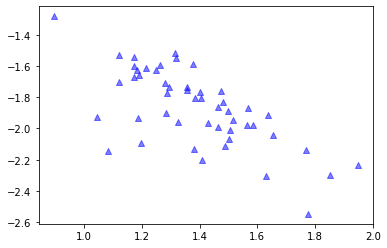

In [33]:
from matplotlib import pyplot as plt

ax = plt.subplot(111)
for label,marker,color in zip(
    range(1,4),('^', 's', 'o'),('b en')):

    plt.scatter(x=X_lda[:,0].real[y == label],
            y=X_lda[:,1].real[y == label],
            marker=marker,
            color=color,
            alpha=0.5,
            label=label_dict[label]
            )

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.title('LDA: Iris projection onto the first 2 linear discriminants')

plt.tick_params(axis="both", which="both", bottom="off", top="off",  
        labelbottom="on", left="off", right="off", labelleft="on")

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)    

plt.grid()
plt.tight_layout
plt.show()


#### Q4: Download the dataset regarding Car Price Prediction from the following link:
https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

### 1.

In [34]:
df_car = pd.read_csv("imports-85.data",header=None,na_values='?')
df_car.columns = ["symboling", "normalized_losses",
"make", "fuel_type", "aspiration","num_doors", "body_style", "drive_wheels",
"engine_location", "wheel_base", "length", "width", "height", "curb_weight", 
"engine_type", "num_cylinders", "engine_size", "fuel_system", "bore", "stroke",
"compression_ratio", "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"] 

In [35]:
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


### 2.

In [36]:
df_car.dropna(subset=['price'],how='all',inplace=True)
df_car.reset_index(drop=True,inplace=True)
numericalColumns=list(df_car.dtypes.index[df_car.dtypes!=object])
df_num=df_car[numericalColumns].fillna(df_car[numericalColumns].mean())
df_car.update(df_num)
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [37]:
categoricalColumns=list(df_car.dtypes.index[df_car.dtypes==object])
df_new=df_car[categoricalColumns].fillna(df_car[categoricalColumns].mode())
df_car.update(df_new)
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [38]:
nanCol=[]
for col in df_car.columns:
    if len(df_car[col].isnull().unique()) > 1:
        nanCol.append(col)
print("NaN columns: ",nanCol)
for col in nanCol:
    df_car[col]=df_car[col].replace(np.nan,df_car[col].mode()[0])
if df_car.isnull().sum().sum() == 0:
    print('Central Tendency Imputation Done!')

NaN columns:  ['num_doors']
Central Tendency Imputation Done!


### 3.

In [39]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(random_state=19)
predict = iso.fit_predict(df_car[['length']])
predict

array([ 1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,
       -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,
        1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [40]:
outlierIndices=np.where(predict==-1)
outlierIndices

(array([  6,   7,   8,  15,  16,  17,  18,  19,  29,  30,  31,  32,  33,
         34,  35,  44,  45,  46,  47,  48,  49,  64,  65,  67,  68,  69,
         70,  71,  95,  98,  99, 100, 103, 106, 107, 110, 111, 126, 134,
        135, 146, 147, 148, 174, 175, 185, 189]),)

In [41]:
df_car['length'].iloc[outlierIndices].values

array([192.7, 192.7, 192.7, 193.8, 197. , 141.1, 155.9, 158.8, 144.6,
       144.6, 150. , 150. , 150. , 163.4, 157.1, 199.6, 199.6, 191.7,
       159.1, 159.1, 159.1, 190.9, 190.9, 202.6, 202.6, 180.3, 208.1,
       199.2, 162.4, 181.7, 184.6, 184.6, 178.5, 198.9, 198.9, 198.9,
       198.9, 181.5, 156.9, 157.9, 158.7, 158.7, 158.7, 183.5, 183.5,
       159.3, 183.1])

### 4.

In [42]:
num_dict = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'zero' : 0,
    'ten' : 10,
    'eleven' : 11,
    'twelve':12
}

In [43]:
df_car['num_doors']=df_car['num_doors'].apply(lambda x: num_dict[x])
df_car['num_cylinders']=df_car['num_cylinders'].apply(lambda x: num_dict[x])
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122.0,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,4,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,4,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [44]:
dummies = pd.get_dummies(df_car[["body_style", "drive_wheels"]])
df_car = pd.concat((df_car,dummies),axis=1)
df_car.drop(columns=["body_style", "drive_wheels"],inplace=True)
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,3,122.0,alfa-romero,gas,std,2,front,88.6,168.8,64.1,...,27,13495.0,1,0,0,0,0,0,0,1
1,3,122.0,alfa-romero,gas,std,2,front,88.6,168.8,64.1,...,27,16500.0,1,0,0,0,0,0,0,1
2,1,122.0,alfa-romero,gas,std,2,front,94.5,171.2,65.5,...,26,16500.0,0,0,1,0,0,0,0,1
3,2,164.0,audi,gas,std,4,front,99.8,176.6,66.2,...,30,13950.0,0,0,0,1,0,0,1,0
4,2,164.0,audi,gas,std,4,front,99.4,176.6,66.4,...,22,17450.0,0,0,0,1,0,1,0,0


In [45]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
encodingFeatures=['make', 'aspiration', 'engine_location','fuel_type']
for attributes in encodingFeatures:
    df_car[attributes]=pd.Series(le.fit_transform(df_car[attributes]))
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,3,122.0,0,1,0,2,0,88.6,168.8,64.1,...,27,13495.0,1,0,0,0,0,0,0,1
1,3,122.0,0,1,0,2,0,88.6,168.8,64.1,...,27,16500.0,1,0,0,0,0,0,0,1
2,1,122.0,0,1,0,2,0,94.5,171.2,65.5,...,26,16500.0,0,0,1,0,0,0,0,1
3,2,164.0,1,1,0,4,0,99.8,176.6,66.2,...,30,13950.0,0,0,0,1,0,0,1,0
4,2,164.0,1,1,0,4,0,99.4,176.6,66.4,...,22,17450.0,0,0,0,1,0,1,0,0


In [46]:
def keyEncode(string,substr):
    if string.count(substr):
        return(1)
    else:
        return(0)

In [47]:
df_car[['fuel_system']]=df_car[['fuel_system']].applymap(lambda x: keyEncode(x,'pfi'))
df_car[['engine_type']]=df_car[['engine_type']].applymap(lambda x: keyEncode(x,'ohc'))
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,3,122.0,0,1,0,2,0,88.6,168.8,64.1,...,27,13495.0,1,0,0,0,0,0,0,1
1,3,122.0,0,1,0,2,0,88.6,168.8,64.1,...,27,16500.0,1,0,0,0,0,0,0,1
2,1,122.0,0,1,0,2,0,94.5,171.2,65.5,...,26,16500.0,0,0,1,0,0,0,0,1
3,2,164.0,1,1,0,4,0,99.8,176.6,66.2,...,30,13950.0,0,0,0,1,0,0,1,0
4,2,164.0,1,1,0,4,0,99.4,176.6,66.4,...,22,17450.0,0,0,0,1,0,1,0,0


### 5.

In [48]:
numeric_columns = df_car.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('price')
print(numeric_columns)
Y = df_car[['price']]

Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_doors', 'engine_location', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_type', 'num_cylinders', 'engine_size',
       'fuel_system', 'bore', 'stroke', 'compression_ratio', 'horsepower',
       'peak_rpm', 'city_mpg', 'highway_mpg', 'body_style_convertible',
       'body_style_hardtop', 'body_style_hatchback', 'body_style_sedan',
       'body_style_wagon', 'drive_wheels_4wd', 'drive_wheels_fwd',
       'drive_wheels_rwd'],
      dtype='object')


In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_car[numeric_columns]=pd.DataFrame(scaler.fit_transform(df_car[numeric_columns]),columns=numeric_columns)
df_car.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,engine_location,wheel_base,length,width,...,highway_mpg,price,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,drive_wheels_4wd,drive_wheels_fwd,drive_wheels_rwd
0,1.725050,0.000000,-1.971717,0.332411,-0.467099,-1.156378,-0.123091,-1.685107,-0.439409,-0.853460,...,-0.542288,13495.0,5.700877,-0.203595,-0.715037,-0.937286,-0.376889,-0.203595,-1.192345,1.296148
1,1.725050,0.000000,-1.971717,0.332411,-0.467099,-1.156378,-0.123091,-1.685107,-0.439409,-0.853460,...,-0.542288,16500.0,5.700877,-0.203595,-0.715037,-0.937286,-0.376889,-0.203595,-1.192345,1.296148
2,0.127193,0.000000,-1.971717,0.332411,-0.467099,-1.156378,-0.123091,-0.710103,-0.244152,-0.185597,...,-0.689386,16500.0,-0.175412,-0.203595,1.398529,-0.937286,-0.376889,-0.203595,-1.192345,1.296148
3,0.926121,1.315931,-1.811395,0.332411,-0.467099,0.864769,-0.123091,0.165748,0.195176,0.148335,...,-0.100993,13950.0,-0.175412,-0.203595,-0.715037,1.066910,-0.376889,-0.203595,0.838683,-0.771517
4,0.926121,1.315931,-1.811395,0.332411,-0.467099,0.864769,-0.123091,0.099646,0.195176,0.243744,...,-1.277779,17450.0,-0.175412,-0.203595,-0.715037,1.066910,-0.376889,4.911721,-1.192345,-0.771517
